In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
%config Completer.use_jedi = False

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/MS/habitual_sentencing/MS_prison_habitual_A_model_inputs.yaml')
# test_sim.simulate_baseline(['prison', 'parole'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 48 results
transitions_data returned 10 results
total_population_data returned 2 results


In [4]:
test_sim.pop_simulations['baseline'].population_projections.loc[test_sim.pop_simulations['baseline'].population_projections.time_step == 0]


KeyError: 'baseline'

In [ ]:
test_sim.pop_simulations['baseline_min'].sub_simulations['50_and_under'].simulation_compartments['prison'].cohorts.cohort_df.sum()

In [ ]:
test_sim.pop_simulations['baseline'].sub_simulations['50_and_under'].simulation_compartments['prison'].cohorts.get_per_ts_population()


In [4]:
TOTAL_YOUNG = 46
TOTAL_OLD = 53

policy_releases = \
    pd.read_csv('../state/MS/habitual_sentencing/MS_data/Outflows Data (Policy A Enacted)-Table 1.csv')
old_releases = policy_releases[policy_releases.age != '50_and_under']
old_releases = old_releases.groupby(
    ['compartment', 'outflow_to', 'time_step']).sum().total_population.reset_index().rename({
        "time_step": "compartment_duration"}, axis=1)
old_releases.compartment_duration += 1

old_releases['age'] = '51_and_up'
young_releases = policy_releases[policy_releases.age == '50_and_under'].rename({
        "time_step": "compartment_duration"}, axis=1)
young_releases.compartment_duration += 1

old_releases = old_releases.append(pd.DataFrame({'compartment_duration': [10], 'total_population': 
                                                [TOTAL_OLD - old_releases.total_population.sum()]})).ffill()
young_releases = young_releases.append(pd.DataFrame({'compartment_duration': [10], 'total_population': 
                                                [TOTAL_YOUNG - young_releases.total_population.sum()]})).ffill()
print(old_releases)
young_releases

  compartment outflow_to  compartment_duration  total_population        age
0      prison     parole                     4                41  51_and_up
1      prison     parole                     5                 0  51_and_up
2      prison     parole                     6                 0  51_and_up
3      prison     parole                     7                 1  51_and_up
4      prison     parole                     8                 0  51_and_up
5      prison     parole                     9                 0  51_and_up
0      prison     parole                    10                11  51_and_up


,compartment,outflow_to,age,compartment_duration,total_population
0,prison,parole,50_and_under,4,21
5,prison,parole,50_and_under,5,2
10,prison,parole,50_and_under,6,0
15,prison,parole,50_and_under,7,1
20,prison,parole,50_and_under,8,0
25,prison,parole,50_and_under,9,4
0,prison,parole,50_and_under,10,18


initialization time:  6.122092008590698
simulation_time:  0.5932800769805908
initialization time:  6.02862286567688
simulation_time:  0.6118390560150146


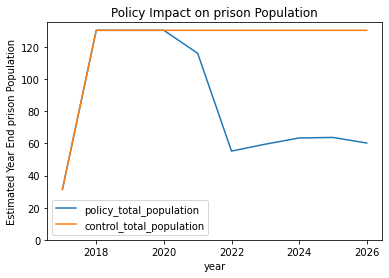

In [5]:
# Policy Option Methods
release_data = {'50_and_under': young_releases,'51_and_up': old_releases}


def remove_life_sentences(age, retroactive=False):
    return partial(CompartmentTransitions.use_alternate_transitions_data,
                   alternate_historical_transitions = release_data[age],
                   retroactive=retroactive)


policy_list_non_retroactive = [SparkPolicy(policy_fn=remove_life_sentences(age, False),
                                           spark_compartment='prison',
                                           sub_population={'age': age},
                                           apply_retroactive=False) for age in release_data]


cost_multipliers = pd.DataFrame({'age': ['51_and_up'], 'multiplier': [2]})
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison', cost_multipliers)

In [7]:
simulation_tag = 'MS_habitual_A'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [6]:
test_sim.output_data['cost_avoidance']

,prison,parole
year,,
2017,0.000000,0.000000
2018,0.000000,0.000000
2019,0.000000,0.000000
2020,0.000000,0.000000
2021,85626.881152,-3609.141461
2022,780144.500201,-32882.802959
2023,1445286.740961,-60918.303096
2024,2083598.214526,-87822.896292
2025,2722293.093778,-114743.649896
